# Semivariogram regularization - tutorial

## Table of Contents:

1. Prepare areal and point data,
2. Set semivariogram parameters,
3. Perform regularization,
4. Visualize regularized semivariogram and analyze algorithm performance,
5. Export semivariogram to text file.

## Level: Intermediate

## Introduction

In this tutorial we learn how to regularize semivariogram of areal dataset of irregular polygons. Procedure is described here: (1) Goovaerts P., Kriging and Semivariogram Deconvolution in the Presence of Irregular Geographical Units, Mathematical Geology 40(1), 101-128, 2008. 

The main idea is to retrieve point support semivariogram from semivariogram of areal data with blocks of different shapes and sizes. It is the case in mining industry, where blocks of aggregates are deconvoluted into smaller units and in the epidemiology, where data is usually aggregated over big administrative units, or in ecology, where observations of species are aggregated over areas or time windows.

In this tutorial we use areal data of Breast Cancer incidence rates in Pennsylvania counties and U.S. Census 2010 data for population blocks.

> Breast cancer rates data is stored in the shapefile in folder `sample_data/areal_data/breast_cancer_rate_per_area_2.shp`.

> Population blocks data is stored in the shapefile in folder `sample_data/population_data/population_blocks.shp`

## Import packages

In [1]:
import numpy as np
import geopandas as gpd

from pyinterpolate.io_ops import prepare_areal_shapefile, get_points_within_area  # Prepare data
from pyinterpolate.semivariance import calculate_semivariance  # Experimental semivariogram
from pyinterpolate.semivariance import RegularizedSemivariogram  # Semivariogram regularization class

import matplotlib.pyplot as plt

## 1) Prepare areal and point data

In [2]:
areal_data = '../sample_data/areal_data/breast_cancer_rate_per_area_2.shp'
point_data = '../sample_data/population_data/population_blocks.shp'

# The important thing before analysis is to check if crs of areal data and point data are the same

areal_crs = gpd.read_file(areal_data).crs
point_support_crs = gpd.read_file(point_data).crs

areal_crs == point_support_crs

True

In [3]:
# We need to know:
# - id column name of areal units,
# - value column name of areal units (usually aggregates),
# - value column name of point support units (usually population)

# Let's check it quickly with geopandas

areal = gpd.read_file(areal_data)
areal.head()

name   rate  id                                           geometry
0  bradford  129.0   0  POLYGON ((-76.14569 41.99885, -76.14364 41.977...
1     bucks  140.9   1  POLYGON ((-75.19130 40.58570, -75.19156 40.585...
2     tioga  127.4   2  POLYGON ((-77.17156 41.99967, -77.16142 41.999...
3     union  118.0   3  POLYGON ((-76.91306 40.88454, -76.91356 40.884...
4   venango  126.0   4  POLYGON ((-79.98155 41.51290, -79.98149 41.512...

In [4]:
# From areal file we are interested in variable deaths (value) and ID (id)
# Now check point support data

point = gpd.read_file(point_data)
point.head()

STATEFP  COUNTYFP  TRACTCE  BLKGRPCE  POPULATION   LATITUDE  LONGITUDE  \
0       42         1    30101         1        2580  40.015805 -77.081172   
1       42         1    30102         1        1136  39.940818 -76.995904   
2       42         1    30102         2        2434  39.980590 -77.035933   
3       42         1    30102         3        2210  39.929089 -77.057235   
4       42         1    30200         1        3202  40.000254 -77.137559   

                     geometry  
0  POINT (-77.08117 40.01581)  
1  POINT (-76.99590 39.94082)  
2  POINT (-77.03593 39.98059)  
3  POINT (-77.05724 39.92909)  
4  POINT (-77.13756 40.00025)

In [6]:
# Column TOT is interesting from our perspective
# Now prepare data for further processing

areal_id = 'id'
areal_val = 'rate'
points_val = 'POPULATION'

areal_data_prepared = prepare_areal_shapefile(areal_data, areal_id, areal_val)

In [7]:
# Check how prepared areal data looks like

areal_data_prepared[0]

array([0, <shapely.geometry.polygon.Polygon object at 0x7f9102f9d6d0>,
       -76.51541607859876, 41.78864564848121, 129.0], dtype=object)

### Clarification:

Every areal dataset is passed as an array of:

[area id, area geometry (polygon), areal centroid x (lon), areal centroid y (lat), value]

In [8]:
points_in_area = get_points_within_area(areal_data, point_data, areal_id_col_name=areal_id,
                                        points_val_col_name=points_val)

In [9]:
# Check how prepared point data looks like

points_in_area[0]

array([57.0,
       array([[ -77.081172,   40.015805, 2580.      ],
       [ -76.995904,   39.940818, 1136.      ],
       [ -77.035933,   39.98059 , 2434.      ],
       [ -77.057235,   39.929089, 2210.      ],
       [ -77.137559,   40.000254, 3202.      ],
       [ -77.160354,   39.95907 , 2298.      ],
       [ -77.318327,   39.973414, 2251.      ],
       [ -77.240078,   39.985105, 1905.      ],
       [ -77.406954,   39.915855, 1446.      ],
       [ -77.298505,   39.923503,  979.      ],
       [ -77.307547,   39.878509, 1289.      ],
       [ -77.360488,   39.873705, 1312.      ],
       [ -77.412175,   39.880362,  803.      ],
       [ -77.227283,   39.926149, 2179.      ],
       [ -77.26064 ,   39.921269, 1588.      ],
       [ -77.173147,   39.868602, 1455.      ],
       [ -77.144613,   39.894567, 1310.      ],
       [ -77.197063,   39.839027, 2163.      ],
       [ -77.119613,   39.84048 , 2646.      ],
       [ -77.106559,   39.807127, 2047.      ],
       [ -77.133681,

### Clarification:

Every point support dataset is passed as an array of:

[area id, array of: [lon, lat, value]]

## 2) Set semivariogram parameters.

Now we must set parameters for areal semivariogram AND point semivariogram. It is very important to understand data well to set them properly, that's why you should always check experimental semivariograms of those datasets to understand how data behaves. We do it for prepared areal and point datasets.

From the practical point of view area semivariogram analysis is more important because we pass into semivariogram regularization parameters of step size and maximum search radius. But we check point's semivariogram too. It is analytical step, to check if spatial process whoch we are using for semivariogram deconvolution is proper, as example if semivariogram shows exponential function then our process will not be properly modeled.

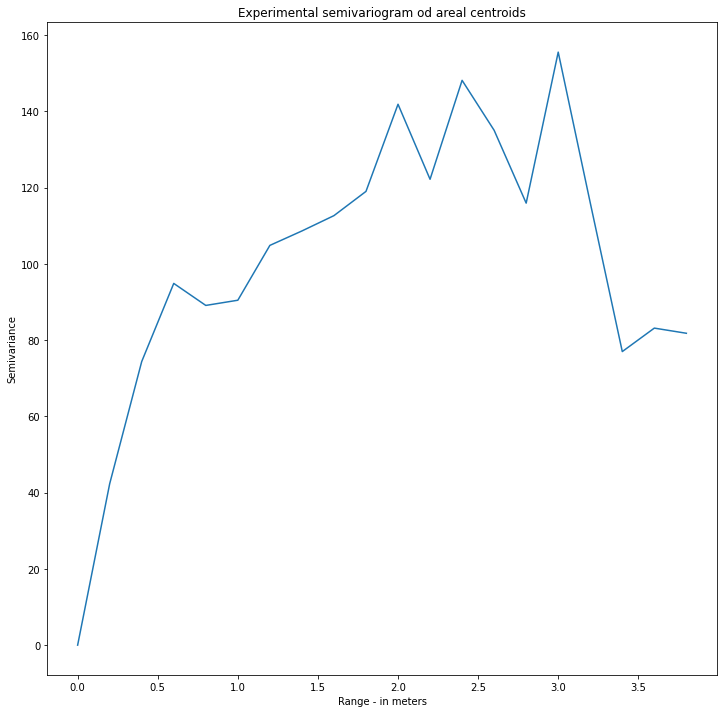

In [10]:
# Check experimental semivariogram of areal data - this cell may be run multiple times 
# before you find optimal parameters

maximum_range = 4
step_size = 0.2

dt = areal_data_prepared[:, 2:]  # x, y, val
exp_semivar = calculate_semivariance(data=dt, step_size=step_size, max_range=maximum_range)

# Plot experimental semivariogram

plt.figure(figsize=(12, 12))
plt.plot(exp_semivar[:, 0], exp_semivar[:, 1])
plt.title('Experimental semivariogram od areal centroids')
plt.xlabel('Range - in meters')
plt.ylabel('Semivariance')
plt.show()

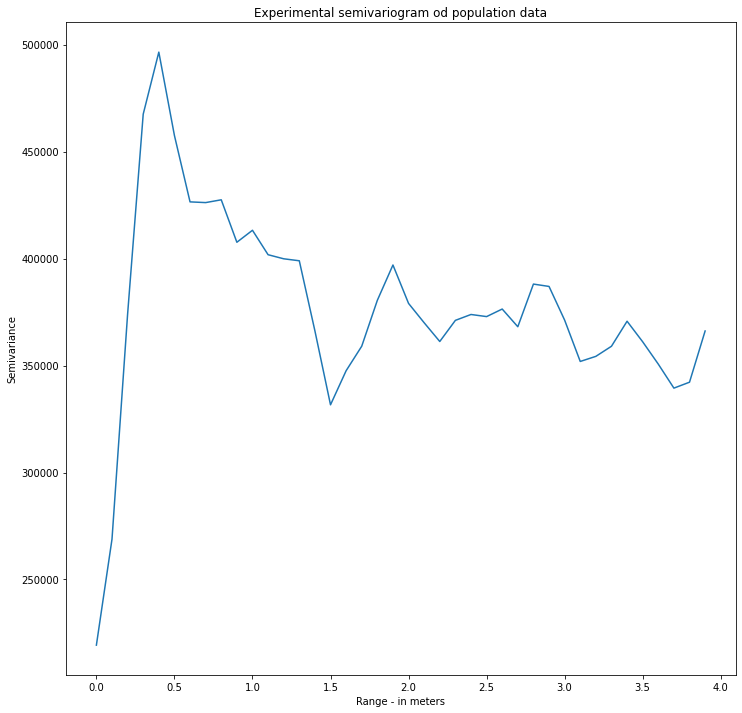

In [11]:
# Check experimental semivariogram of point data - this cell may be run multiple times 
# before you find optimal parameters

def build_point_array(points):
    a = None

    for rec in points:
        if a is None:
            a = rec.copy()
        else:
            a = np.vstack((a, rec))

    return a

maximum_point_range = 4
step_size_points = 0.1


pt = build_point_array(points_in_area[:, 1])  # x, y, val
exp_semivar = calculate_semivariance(data=pt, step_size=step_size_points, max_range=maximum_point_range)

# Plot experimental semivariogram

plt.figure(figsize=(12, 12))
plt.plot(exp_semivar[:, 0], exp_semivar[:, 1])
plt.title('Experimental semivariogram od population data')
plt.xlabel('Range - in meters')
plt.ylabel('Semivariance')
plt.show()

### Clarification:

After few adjustements we have prepared semivariogram parameters for area and point support data. The next step is to create ```RegularizedSemivariogram``` model. We have mutiple parameters to choose and at the beginning it is hard to find the best fit, so try to avoid multiple loops because it is a time-consuming operation.

The program is designed to first **fit()** the model and later to **transform()** it.

When you **fit()** a model you have multiple parameters to control: 
* areal_data: areal data prepared with the function prepare_areal_shapefile(), where data is a numpy array
    in the form: [area_id, area_geometry, centroid coordinate x, centroid coordinate y, value],
* areal_lags: list of lags between each distance,
* areal_step_size: step size between each lag, usually it is a half of distance between lags,
* point_support_data: point support data prepared with the function get_points_within_area(), where data is
    a numpy array in the form: [area_id, [point_position_x, point_position_y, value]],
* ranges: (int) number of ranges to test during semivariogram fitting. More steps == more accurate nugget
    and range prediction, but longer calculations,
* weighted_lags: (bool) lags weighted by number of points; if True then during semivariogram fitting error
    of each model is weighted by number of points for each lag. In practice it means that more reliable data
    (lags) have larger weights and semivariogram is modeled to better fit to those lags,
* store_models: (bool) if True then experimental, regularized and theoretical models are stored in lists
    after each iteration. It is important for a debugging process.

We set ranges to 64, then we will weight lags and we do not store semivariograms and semivariogram models.

After fitting we perform **transform()**. This function has few parameters to control regularization process, but we leave them as default with one exception: we set max_iters parameter to 5.

This process of fitting and transforming takes some time, so it's good idea to run it and do something else...

## 3) Regularize semivariogram

In [12]:
reg_mod = RegularizedSemivariogram()

In [14]:
reg_mod.fit(areal_data=areal_data_prepared,
            areal_step_size=step_size, max_areal_range=maximum_range,
            point_support_data=points_in_area, ranges=32, weighted_lags=True, store_models=False)

100%|██████████| 67/67 [01:25<00:00,  1.28s/it]


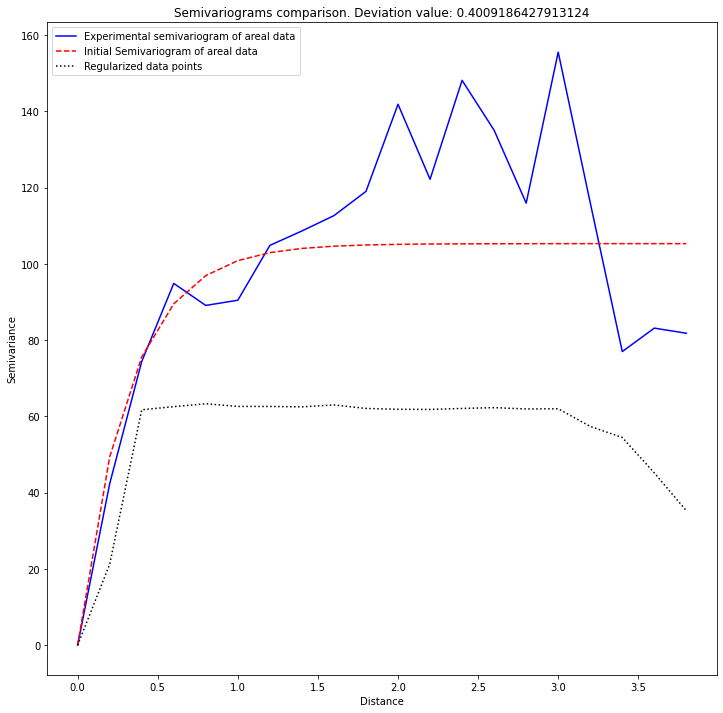

In [15]:
# Check initial experimental, theoretical and regularized semivariograms

lags = reg_mod.experimental_semivariogram_of_areal_data[:, 0]
plt.figure(figsize=(12, 12))
plt.plot(lags, reg_mod.experimental_semivariogram_of_areal_data[:, 1], color='b')
plt.plot(lags, reg_mod.initial_theoretical_model_of_areal_data.predict(lags), color='r', linestyle='--')
plt.plot(lags, reg_mod.initial_regularized_model, color='black', linestyle='dotted')
plt.legend(['Experimental semivariogram of areal data', 'Initial Semivariogram of areal data',
            'Regularized data points'])
plt.title('Semivariograms comparison. Deviation value: {}'.format(reg_mod.initial_deviation))
plt.xlabel('Distance')
plt.ylabel('Semivariance')
plt.show()

#### NOTE:

There's a large relative difference between regularized semivariance and theoretical semivariogram of areal data. What's more important: sill is reached approx. at 1 degree distance... So there is a problem of scale: spatial correlation potentially exists but at much smaller scales than we are able to observe and we lost some information near the origin.

In [16]:
reg_mod.transform(max_iters=5)

100%|██████████| 67/67 [02:01<00:00,  1.81s/it]


**NOTE:**

Operation is slow in the beta version of library so try to find some different task to do when process runs.

## 4) Visualize and check semivariogram

### Clarification:

Process is fully automatic but we can check how it baheaved through each iteration. We can analyze deviation change (most important variable, mean absolute difference between regularized and theoretical models) with build-in method but if you are more interested in the algorithm stability you can analyze weight change over each iteration too.

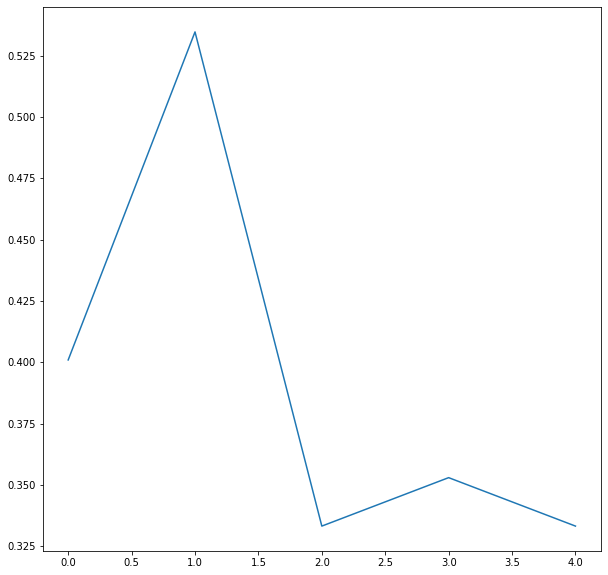

In [17]:
# First analyze deviation

plt.figure(figsize=(10, 10))
plt.plot(reg_mod.deviations)
plt.show()

### Clarification:

Deviation between regularized semivariogram and theoretical model is smaller with each step which is a good sign that our algorithm works properlly. We've performed only five iterations and we may expect that deviation drops later too.

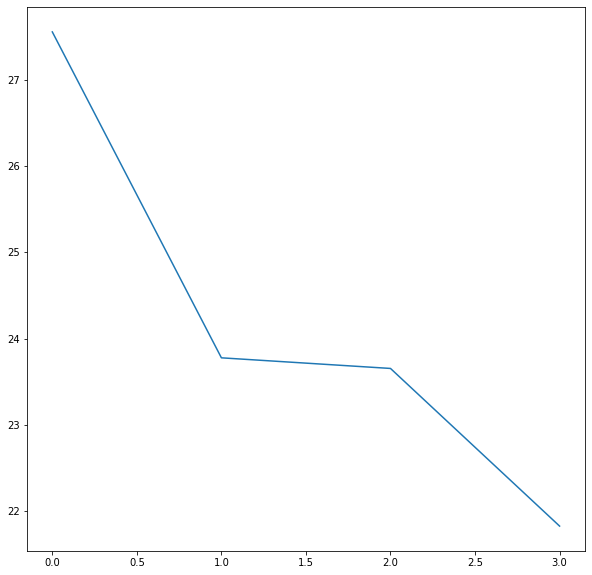

In [18]:
# Check weights - it is important to track problems with algorithm, esepcially if sum of weights is oscillating
# then it may be a sign of problems with data, model or (hopefully not!) algorithm itself.

weights = reg_mod.weights
weights = [sum(w) for w in weights]

plt.figure(figsize=(10,10))
plt.plot(weights)
plt.show()

#### NOTE:

Weights are smaller with each iteration. It is normal behavior of algorithm.

#### NOTE:

The most important part is to compare semivariograms! You can see that Optimized Model is equal to Initial Semivariogram of areal data: our model is not better than normal kriging of areal centroids.

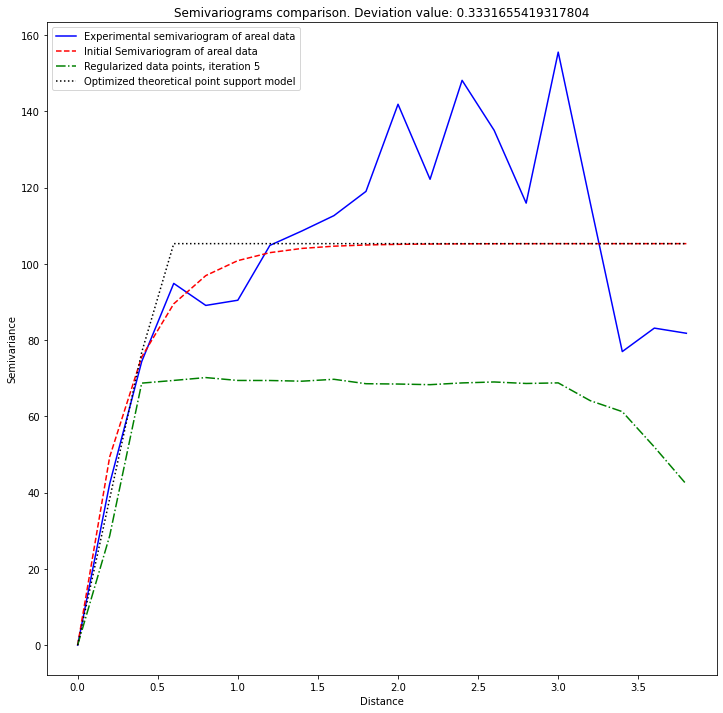

In [19]:
reg_mod.show_semivariograms()

### Clarification:

Experimental semivariogram is a semivariogram of areal centroids. Then theoretical semivariogram is used to describe this experimental (empirical) semivariogram. Regularization process is to find semivariogram close enough to the theoretical semivariogram, which describes ongoing process with the new support (in this case with population units). You may see that experimental semivariogram has exponential growth near the origin. It could mean that in this scale of analysis we lost some information.

Anyway, we can store this regularized semivariogram properties for the further analysis and Kriging and we will perform it, even with the parameters which are not well fitted to the data.

## 5) Export semivariogram to text file

In [21]:
# Export semivariogram to the text file. This is important step because calculations are slow...
# and it is better to not repeat them.
# We will use buil-in method: export_regularized where we pass only filename our semivariogram
# parameters are stored for other tasks.

reg_mod.export_regularized_model('regularized_model.csv')

---